### RNN with Attention (Possible solution)

In [ ]:
# -*- coding: utf-8 -*-
"""
Wind Turbine Power Prediction with RNNs + Attention

This lab uses an Attention-enhanced Recurrent Neural Network to predict wind turbine power output.
"""

# Step 0: Load libraries & Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Layer
from tensorflow.keras.callbacks import EarlyStopping
import math

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Step 1: Prepare the Data
df = pd.read_csv("/content/T1.csv")



In [ ]:
# Inspect data
print(df.shape)
print(df.head())

# Convert Date/Time to datetime
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format='%d %m %Y %H:%M')

# Check for missing values
print(df.isnull().sum())

(50530, 5)
          Date/Time  LV ActivePower (kW)  Wind Speed (m/s)  \
0  01 01 2018 00:00           380.047791          5.311336   
1  01 01 2018 00:10           453.769196          5.672167   
2  01 01 2018 00:20           306.376587          5.216037   
3  01 01 2018 00:30           419.645905          5.659674   
4  01 01 2018 00:40           380.650696          5.577941   

   Theoretical_Power_Curve (KWh)  Wind Direction (°)  
0                     416.328908          259.994904  
1                     519.917511          268.641113  
2                     390.900016          272.564789  
3                     516.127569          271.258087  
4                     491.702972          265.674286  
Date/Time                        0
LV ActivePower (kW)              0
Wind Speed (m/s)                 0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
dtype: int64


In [ ]:
# Convert Date/Time to datetime format
df['Date/Time'] = pd.to_datetime(df['Date/Time'])

# Select relevant features
features = ['LV ActivePower (kW)', 'Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)']
data = df[features].fillna(method='ffill').values  # Forward-fill missing values

# Normalize features
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)


/tmp/ipython-input-1003703817.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = df[features].fillna(method='ffill').values  # Forward-fill missing values


In [ ]:
# Step 2: Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  # target is ActivePower
    return np.array(X), np.array(y)

SEQ_LENGTH = 24  # Use last 24 time steps to predict next
X, y = create_sequences(data_scaled, SEQ_LENGTH)
print(f"X shape: {X.shape}, y shape: {y.shape}")


X shape: (50506, 24, 3), y shape: (50506,)


In [ ]:
# Step 3: Split the data
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Train X: {X_train.shape}, Train y: {y_train.shape}")
print(f"Test X: {X_test.shape}, Test y: {y_test.shape}")

# Step 4: Define a Custom Attention Layer
class Attention(Layer):
    def __init__(self):
        super(Attention, self).__init__()

    def call(self, inputs):
        # inputs shape: (batch, time_steps, features)
        score = tf.nn.tanh(inputs)  # Alignment scores
        attention_weights = tf.nn.softmax(score, axis=1)  # Softmax across time steps
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)  # Sum over time
        return context_vector

Train X: (40404, 24, 3), Train y: (40404,)
Test X: (10102, 24, 3), Test y: (10102,)


In [ ]:
# Step 5: Build the RNN Model with Attention
input_layer = Input(shape=(SEQ_LENGTH, len(features)))
x = LSTM(64, return_sequences=True)(input_layer)
x = Dropout(0.2)(x)
x = LSTM(32, return_sequences=True)(x)
x = Dropout(0.2)(x)

attention = Attention()(x)
output = Dense(1)(attention)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='mse')
model.summary()

# Step 6: Compile and Train the Model
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 24, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 24, 64)         │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 24, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 31s 27ms/step - loss: 0.0338 - val_loss: 0.0090
Epoch 2/100
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 36s 36ms/step - loss: 0.0129 - val_loss: 0.0063
Epoch 3/100
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 36s 36ms/step - loss: 0.0092 - val_loss: 0.0049
Epoch 4/100
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 28s 28ms/step - loss: 0.0076 - val_loss: 0.0053
Epoch 5/100
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 27s 27ms/step - loss: 0.0071 - val_loss: 0.0044
Epoch 6/100
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.0067 - val_loss: 0.0051
Epoch 7/100
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step - loss: 0.0065 - val_loss: 0.0049
Epoch 8/100
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - loss: 0.0064 - val_loss: 0.0049
Epoch 9/100
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.0063 - val_loss: 0.0055
Epoch 10/100
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.0062 - val_loss: 0.0052
Epoch 11/100
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - loss: 0.0061 - val_loss: 0.00

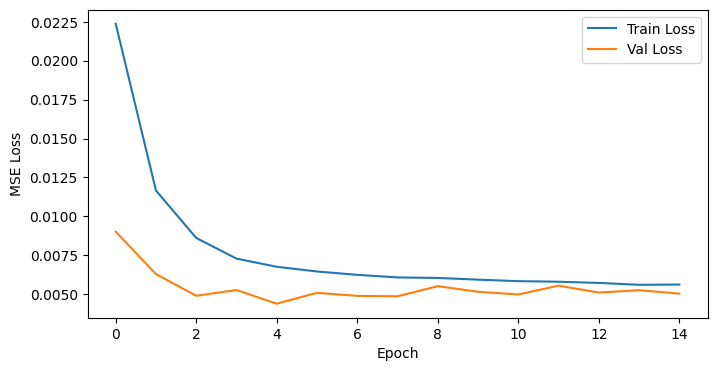

In [ ]:
# Plot training history
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

In [ ]:
# Predict
y_pred = model.predict(X_test)

# Inverse scale
y_test_actual = scaler.inverse_transform(
    np.concatenate([y_test.reshape(-1,1), np.zeros((len(y_test), 2))], axis=1)
)[:,0]

y_pred_actual = scaler.inverse_transform(
    np.concatenate([y_pred, np.zeros((len(y_pred), 2))], axis=1)
)[:,0]


316/316 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


In [ ]:
# Metrics
mse = mean_squared_error(y_test_actual, y_pred_actual)
rmse = math.sqrt(mse)
r2 = r2_score(y_test_actual, y_pred_actual)

print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")

MSE: 60323.57, RMSE: 245.61, R²: 0.9665


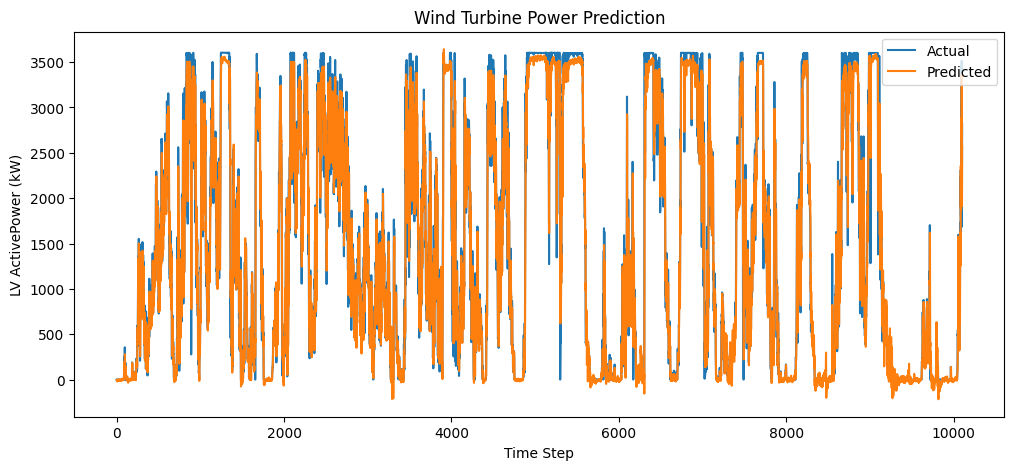

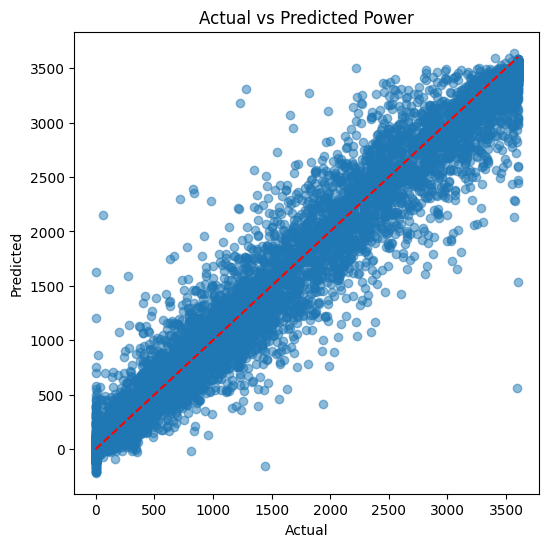

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(y_test_actual, label='Actual')
plt.plot(y_pred_actual, label='Predicted')
plt.xlabel('Time Step')
plt.ylabel('LV ActivePower (kW)')
plt.title('Wind Turbine Power Prediction')
plt.legend()
plt.show()

# Scatter plot
plt.figure(figsize=(6,6))
plt.scatter(y_test_actual, y_pred_actual, alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Power')
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'r--')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


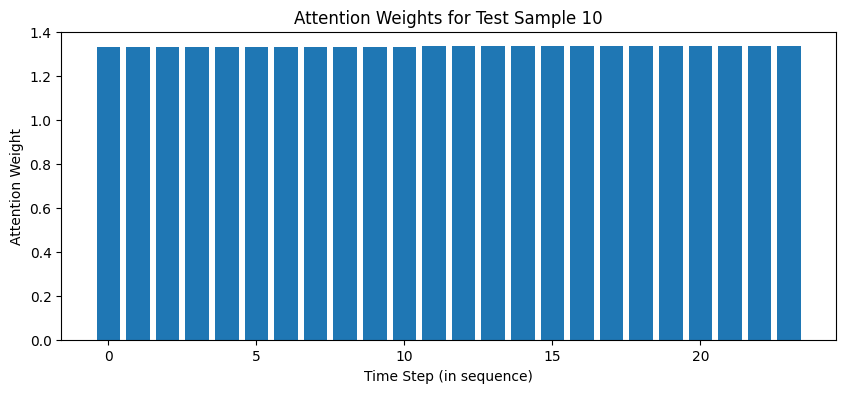

Actual Power: 0.00 kW
Predicted Power: -29.87 kW


In [ ]:
# We'll modify the Attention layer to also output weights
class AttentionWithWeights(Layer):
    def __init__(self):
        super(AttentionWithWeights, self).__init__()

    def call(self, inputs):
        # Alignment scores
        score = tf.nn.tanh(inputs)
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights  # Return both

# Rebuild the model with attention weights
input_layer = Input(shape=(SEQ_LENGTH, len(features)))
x = LSTM(64, return_sequences=True)(input_layer)
x = Dropout(0.2)(x)
x = LSTM(32, return_sequences=True)(x)
x = Dropout(0.2)(x)

attention_layer = AttentionWithWeights()
context_vector, attention_weights = attention_layer(x)
output = Dense(1)(context_vector)

model_with_attention = Model(inputs=input_layer, outputs=[output, attention_weights])
model_with_attention.compile(optimizer='adam', loss='mse')

# Load previously trained weights for demonstration
# NOTE: You can train this model similarly and save weights to reuse
# model_with_attention.set_weights(model.get_weights())

# Select a sample from test set
sample_index = 10  # Any index you like
sample_input = X_test[sample_index:sample_index+1]

# Get prediction and attention weights
pred, att_weights = model_with_attention.predict(sample_input)

# att_weights shape: (1, time_steps, features)
# Sum attention across features to get per-timestep attention
att_weights_per_timestep = np.sum(att_weights[0], axis=-1)

# Plot attention weights
plt.figure(figsize=(10,4))
plt.bar(range(SEQ_LENGTH), att_weights_per_timestep)
plt.xlabel('Time Step (in sequence)')
plt.ylabel('Attention Weight')
plt.title(f'Attention Weights for Test Sample {sample_index}')
plt.show()

# Also display predicted vs actual for this sample
y_actual = scaler.inverse_transform(
    np.concatenate([y_test[sample_index:sample_index+1].reshape(-1,1), np.zeros((1,2))], axis=1)
)[:,0]

y_pred_val = scaler.inverse_transform(
    np.concatenate([pred, np.zeros((1,2))], axis=1)
)[:,0]

print(f"Actual Power: {y_actual[0]:.2f} kW")
print(f"Predicted Power: {y_pred_val[0]:.2f} kW")

| Metric | Value    |
| ------ | ------   |
| RMSE   | 245.61   |
| R²     | 0.9665   |
| MSE    | 60323.57 |